In [1]:
# General imports
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import collections
import os
import time
import re
import itertools

# Data Science
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from analysis_utils import *

In [2]:
labels = ["1:1","1:2","1:4","1:6","1:10","1:25", "1:50", r"1:$10^2$", r"1:$10^3$", r"1:$10^6$"]
costs = np.array([2, 3, 4, 6, 10, 25, 50, 100, 1000, 1000000])
axis_costs = np.arange(1,11,1)
cxlim = [0.8, 10.15]

In [3]:
data = load_results()

## Best result

In [11]:
accepted_results = data[data["recall"] == data["recall"].max()]
accepted_results[accepted_results["precision"] == accepted_results["precision"].max()]

,id,n_experiment,nlp,algorithm,cost_ratio,precision,recall
1030,1031,9,Bigrams,SVM,6,0.511351,1


In [110]:
accepted_results.loc[(accepted_results["nlp"] == "Bigrams") & (accepted_results["algorithm"] == "SVM") 
                     & (accepted_results["cost_ratio"] == 6)]

,id,n_experiment,nlp,algorithm,cost_ratio,precision,recall
1030,1031,9,Bigrams,SVM,6,0.511351,1
1034,1035,74,Bigrams,SVM,6,0.509829,1


## Best results

In [111]:
accepted_results[accepted_results["precision"] > 0.48].sort(["precision"], ascending=False)

,id,n_experiment,nlp,algorithm,cost_ratio,precision,recall
1030,1031,9,Bigrams,SVM,6,0.511351,1
1034,1035,74,Bigrams,SVM,6,0.509829,1
40,41,9,None,Naive Bayes,10,0.494311,1
342,343,9,Combination,Naive Bayes,10,0.493177,1
345,346,93,Combination,Naive Bayes,10,0.491014,1
343,344,74,Combination,Naive Bayes,10,0.489272,1
1044,1045,74,Bigrams,SVM,10,0.480656,1
1054,1055,74,Bigrams,SVM,25,0.480656,1
1064,1065,74,Bigrams,SVM,50,0.480656,1
1073,1074,74,Bigrams,SVM,100,0.480656,1


## Best Result

In [128]:
get_best("Naive Bayes")

,id,n_experiment,nlp,algorithm,cost_ratio,precision,recall
40,41,9,None,Naive Bayes,10,0.494311,1


In [171]:
get_best("SVM")

,id,n_experiment,nlp,algorithm,cost_ratio,precision,recall
1030,1031,9,Bigrams,SVM,6,0.511351,1


In [129]:
get_best("Random Forest")

,id,n_experiment,nlp,algorithm,cost_ratio,precision,recall
698,699,12,Bigrams,Random Forest,1000000,0.725691,0.965359


## Analyzing preprocessing techniques

### Steming vs bigrams vs combination

In [60]:
data1 = data.loc[(data["nlp"] == "Bigrams")]["recall"]
data2 =  data.loc[(data["nlp"] == "Stemming")]["recall"]
data3 =  data.loc[(data["nlp"] == "Combination")]["recall"]

are_different(data1, data2, threshold=0.01, parametric=False)
are_different(data1, data3, threshold=0.01, parametric=False)
are_different(data2, data3, threshold=0.01, parametric=False)

Statistically non-significant different results
Statistically significant different results
Statistically significant different results


## Analyzing algorithms

### Bayes vs SVM vs Random Forest

In [73]:
data1 = data.loc[(data["algorithm"] == "Random Forest")]["recall"]
data2 =  data.loc[(data["algorithm"] == "Naive Bayes")]["recall"]
data3 =  data.loc[(data["algorithm"] == "SVM")]["recall"]

are_different(data1, data2, threshold=0.001, parametric=False)
are_different(data1, data3, threshold=0.001, parametric=False)
are_different(data2, data3, threshold=0.001, parametric=False)

Statistically significant different results
Statistically significant different results
Statistically significant different results


In [34]:
recalls = []
precisions = []
for m in ["Naive Bayes", "Random Forest", "SVM", "Baseline"]:
    recalls.append(get_best_by_cost("recall", m , "recall"))
    precisions.append(get_best_by_cost("recall", m , "precision"))

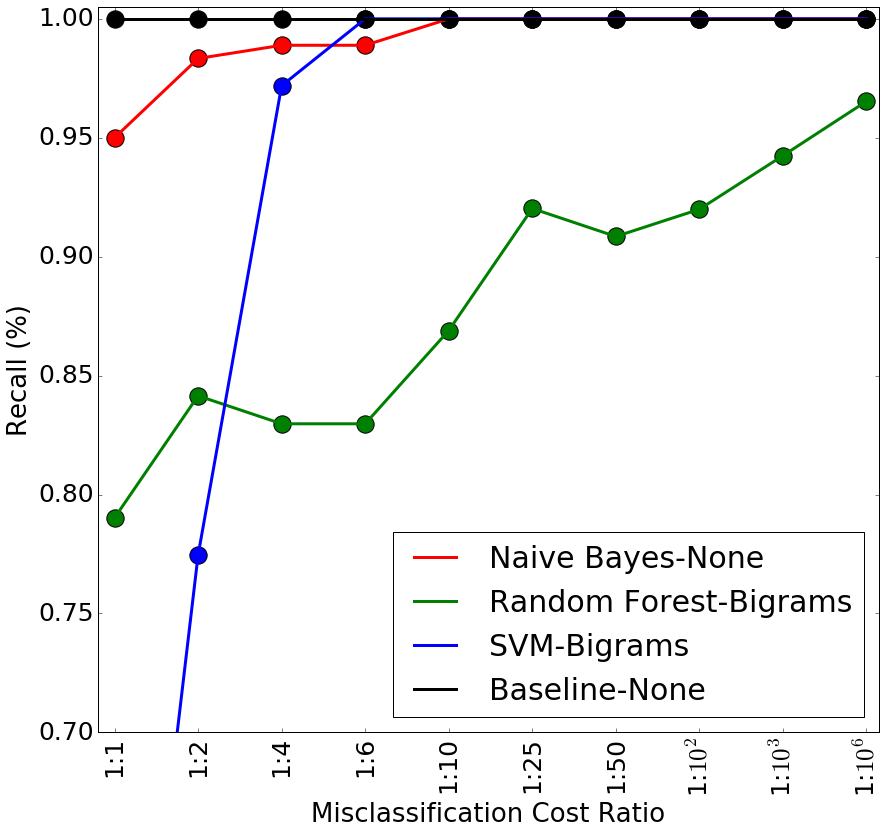

In [37]:
plot_image(axis_costs, recalls, title="RECALL", ylim = [0.70, 1.005], 
           xlim = cxlim, file_name="recall", labels=labels, ylabel="Recall (%)", 
           loc='lower righ', markers="<Do|")

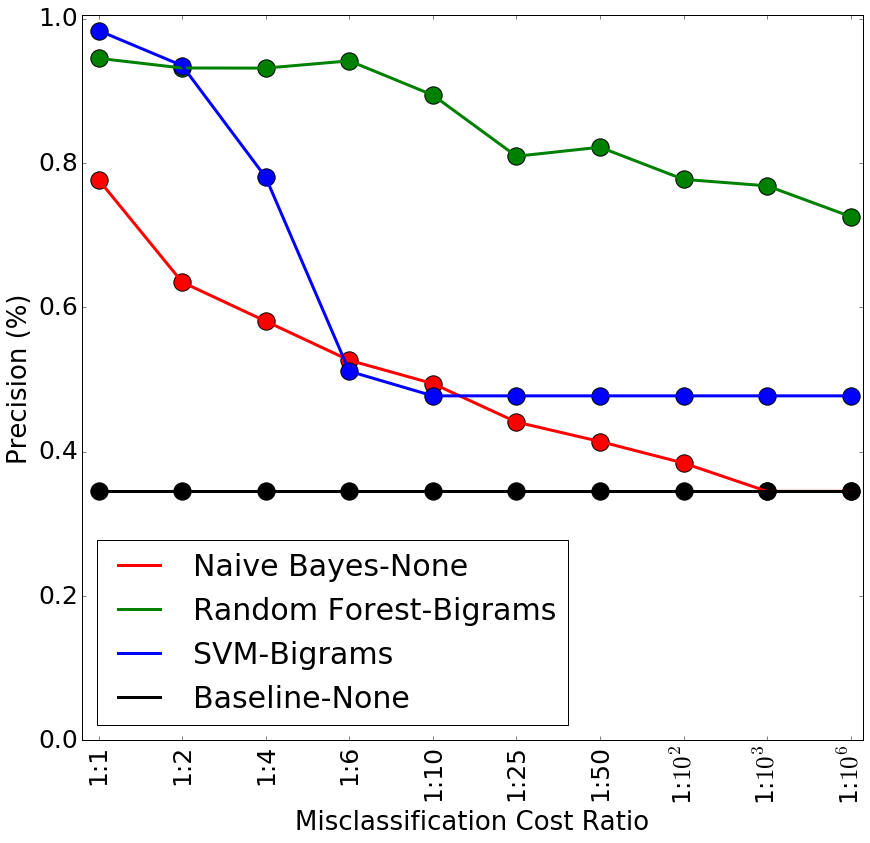

In [38]:
plot_image(axis_costs, precisions, title="RECALL", ylim = [0., 1.005], 
           xlim = cxlim, file_name="precision", labels=labels, ylabel="Precision (%)", 
           loc='lower righ', markers="<Do|")